# SYSID - Atividade 08

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [1]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelos
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import r2_score

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [2]:
binary = os.path.join(os.getcwd(), 'data', 'bywell.pkl')
print(binary)
data = {}
with open(binary, 'rb') as bin_file:
    try:
        while True:
            content = pickle.load(bin_file)
            print('Read entry of events:', content[0])
            data[content[0]] = content[1]
            del content
    except EOFError:
        pass

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/SPE-DataSet/data/bywell.pkl
Read entry of events: ALBATROSS
Read entry of events: ARCHAEOPTERYX
Read entry of events: AVOCET
Read entry of events: BEE-EATER
Read entry of events: BLUEBIRD
Read entry of events: CANARY
Read entry of events: CARDINAL
Read entry of events: CASSOWARY
Read entry of events: CRANE
Read entry of events: CROW
Read entry of events: CUCKOO
Read entry of events: DUCK
Read entry of events: EAGLE
Read entry of events: EGRET
Read entry of events: EMU
Read entry of events: FALCON
Read entry of events: FINCH
Read entry of events: FLAMINGO
Read entry of events: GOOSE
Read entry of events: HARPY
Read entry of events: HAWK
Read entry of events: HERON
Read entry of events: HUMMINGBIRD
Read entry of events: IBIS
Read entry of events: JAY
Read entry of events: KITE
Read entry of events: LARK
Read entry of events: LOON
Read entry of events: LORIKEET
Read entry of events: MACAW
Read entry of events: MYNAH
Read entry of e

### 0.2 - Visualizando dados

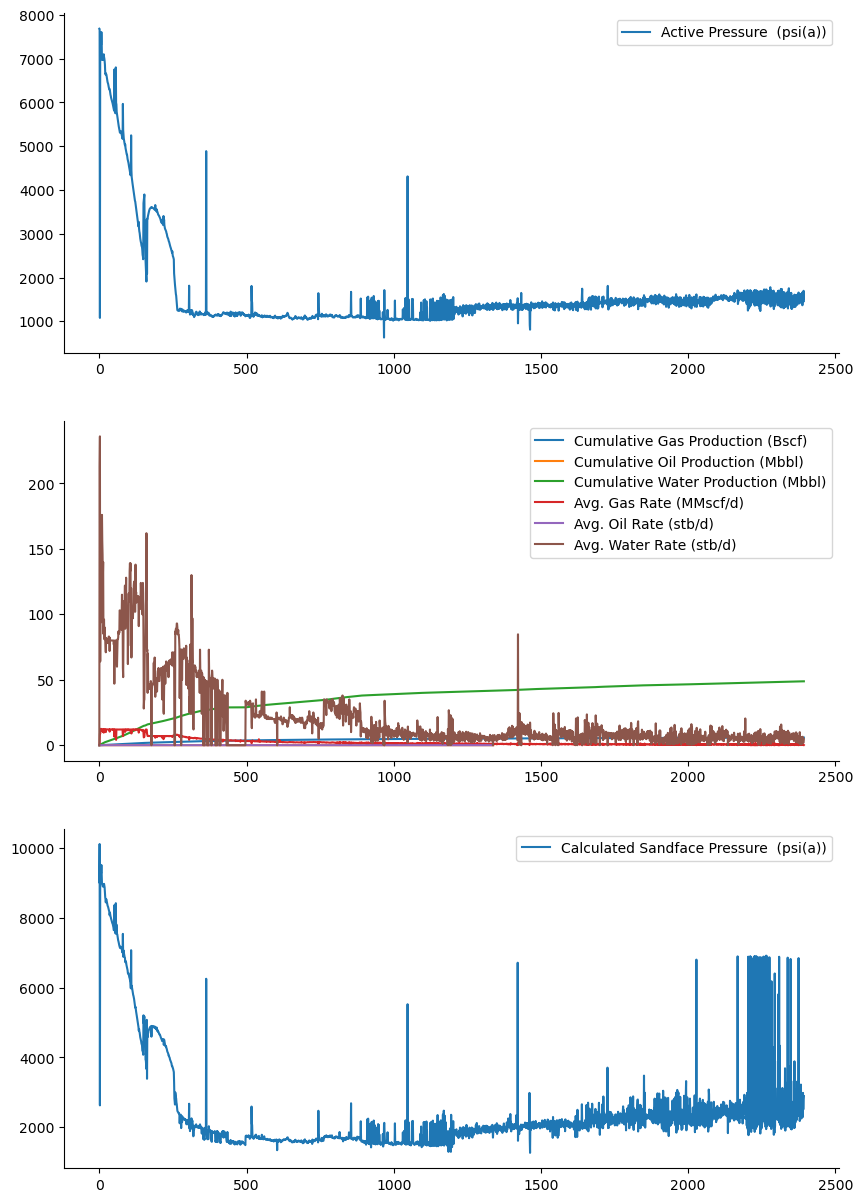

In [3]:
case = "CASSOWARY"

data_case = data[case]

filt_vars_IN_P = [
    #"Time (Days)",
    "Active Pressure  (psi(a))",
    #"Line Pressure  (psi(a))",
    #"Cumulative Gas Production (Bscf)",
    #"Cumulative Oil Production (Mbbl)",
    #"Cumulative Water Production (Mbbl)",
    #"Avg. Gas Rate (MMscf/d)",	
    #"Avg. Oil Rate (stb/d)",
    #"Avg. Water Rate (stb/d)",
]

filt_vars_IN_Q = [
    #"Time (Days)",
    #"Active Pressure  (psi(a))",
    #"Line Pressure  (psi(a))",
    "Cumulative Gas Production (Bscf)",
    "Cumulative Oil Production (Mbbl)",
    "Cumulative Water Production (Mbbl)",
    "Avg. Gas Rate (MMscf/d)",	
    "Avg. Oil Rate (stb/d)",
    "Avg. Water Rate (stb/d)",
]

filt_vars_OUT = [
    "Calculated Sandface Pressure  (psi(a))",
]

time = data_case['Time (Days)']
fig, ax = plt.subplots(3,1, figsize=(10, 15))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], label=var)
for var in filt_vars_OUT:
    ax[2].plot(time, data_case[var], label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()

In [4]:
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P+filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [5]:
p_train = 0.5 #50% treino

### 1.2 - Separando os conjuntos

In [6]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [7]:
print(
    X1_tr.shape,
    X1_te.shape
)

(669, 7) (669, 7)


### 1.3 - Normalizando as variáveis

In [8]:
scaler_X = MinMaxScaler().fit(X1_tr)
scaler_y = MinMaxScaler().fit(y_tr)

X1_tr = scaler_X.transform(X1_tr)
X1_te = scaler_X.transform(X1_te)

y_tr  = scaler_y.transform(y_tr)
y_te  = scaler_y.transform(y_te) 

### 1.4 - Aplicando PCA no vetor de entrada

In [9]:
pca_X = PCA(0.99).fit(X1_tr)

X1_tr = pca_X.transform(X1_tr)
X1_te = pca_X.transform(X1_te)

print(X1_tr.shape)

(669, 3)


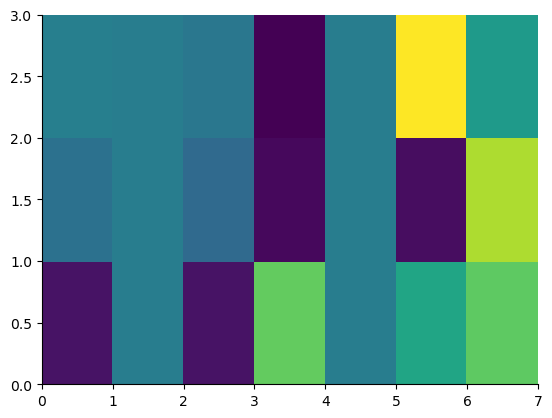

In [10]:
plt.pcolor(pca_X.components_)

## Passo 2 - Iniciando a construção do modelo ARMAX/NARMAX

Para essa atividade, vamos usar a biblioteca sysidentpy. Essa biblioteca guarda grandes similaridades com bibliotecas da área de machine learning, como `scikit-learn`, `tensorflow` e `pytorch`.
Como na <a href="../Atividade06/Atividade06.ipynb">Atividade 06</a> o modelo que usamos de base mostrou-se divergente para a simulação livre, vamos aqui tentar propor um modelo ligeiramente diferente de base, com `na = nb = 6`. Além disso, vamos adicionar 4 termos não-lineares por padrão nos coeficientes do ajuste por meio do parâmetro n_terms.

### 2.1 - Selecionando a arquitetura (NARMAX)

Para esse caso, como o númeroo de termos tende a crescer muito, vamos deixar o sysidentpy selecionar a ordem de nossos modelos

In [11]:
basis_function = Polynomial(degree=2)
na = 6
nb = [6] * X1_tr.shape[1]
ne = 1
n_terms = 2
model_NARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    #extended_least_squares=True,
)

### 2.3 - Selecionando arquitetura (ARMAX)

In [12]:
basis_function = Polynomial(degree=1)
na = 6
nb = [6] * X1_tr.shape[1]
ne = 1
n_terms = 5
model_ARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    extended_least_squares=True,
)

## Passo 3 - Realizando ajuste inicial

### 3.1 - Performando o ajuste

In [13]:
model_NARMAX.fit(X=X1_tr, y=y_tr)
model_ARMAX.fit(X=X1_tr, y=y_tr)

/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:476: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 55 
  self.info_values = self.information_criterion(reg_matrix, y)
/home/pedro-linux/miniconda3/envs/control/lib/python3.10/site-packages/sysidentpy/model_structure_selection/forward_regression_orthogonal_least_squares.py:476: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 10 
  self.info_values = self.information_criterion(reg_matrix, y)


### 3.2 - Visualizando os resultados (NARMAX)

In [14]:
r = pd.DataFrame(
    results(
        model_NARMAX.final_model, model_NARMAX.theta, model_NARMAX.err,
        model_NARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-2),2.9310E-01,9.90444522E-01
1,y(k-1),4.4309E-01,2.32645594E-03
2,y(k-3),1.2860E-01,4.39133964E-04
3,y(k-6),1.2394E-01,7.16086762E-05


### 3.3 - Visualizando os resultados (ARMAX)

In [15]:
r = pd.DataFrame(
    results(
        model_ARMAX.final_model, model_ARMAX.theta, model_ARMAX.err,
        model_ARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-2),-1.3360E-01,9.90444522E-01
1,y(k-1),1.3458E+00,2.32645594E-03
2,y(k-3),-1.6982E-01,4.39133964E-04
3,y(k-6),-4.4839E-02,7.16086762E-05


### 3.4 - Comentários

Nota-se ao olharmos os valores do ajuste que os coeficientes lineares ficam sendo os de maior peso em ambos os casos. Além disso, a ordem dos coeficientes lineares em ambos os ajustes é a mesma, de modo que é esperado que os ajustes fiquem bem próximos, com os coeficientes lineares sendo os dominantes e pouco ganho n aplicação do NARMAX.

## Passo 4 - Comparando os resultados

### 4.1 - Calculando predição OSA

In [16]:
y_tr_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

y_tr_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

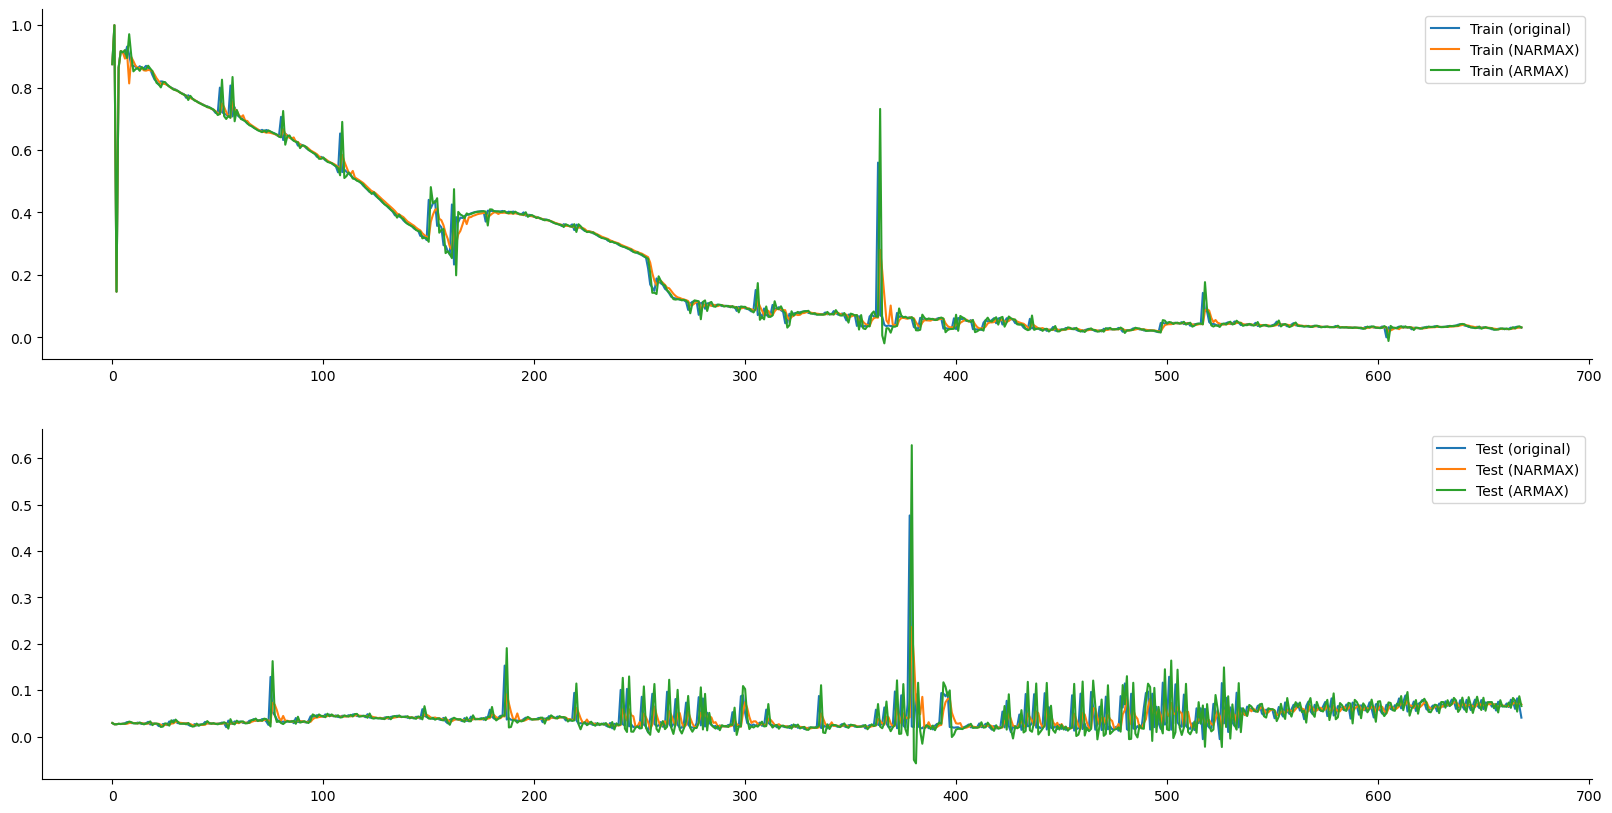

In [17]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_OSA_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_OSA_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_OSA_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_OSA_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [18]:
print('ARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_ARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_NARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_NARMAX))

ARMAX Results:
R2 score for OSA prediction (train) : 0.9765410575132479
R2 score for OSA prediction (test)  : -1.3835703830018558

NARMAX Results:
R2 score for OSA prediction (train) : 0.9883005197022229
R2 score for OSA prediction (test)  : -0.09124664899337587


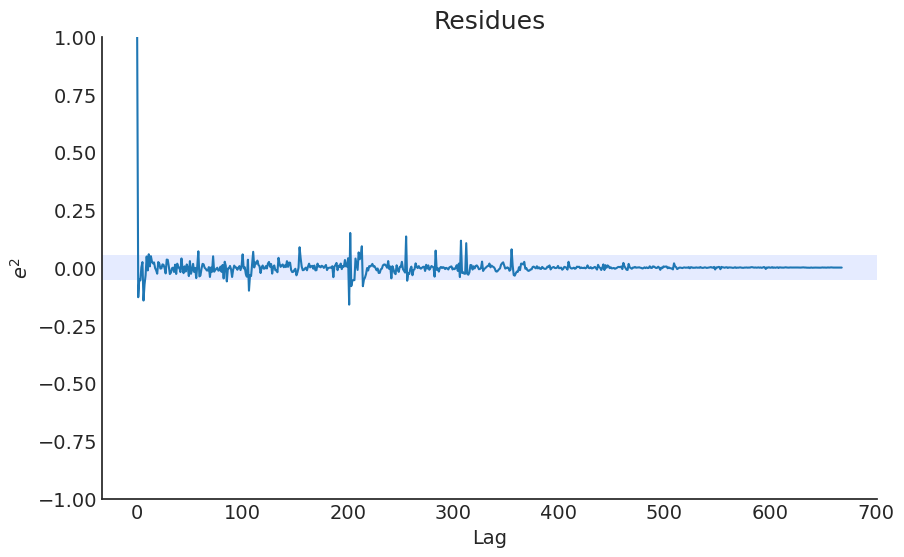

In [19]:
ee = compute_residues_autocorrelation(y_tr, y_tr_pr_OSA_NARMAX)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

### 4.3 - Calculando predição FS

In [20]:
steps = None
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)
y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)

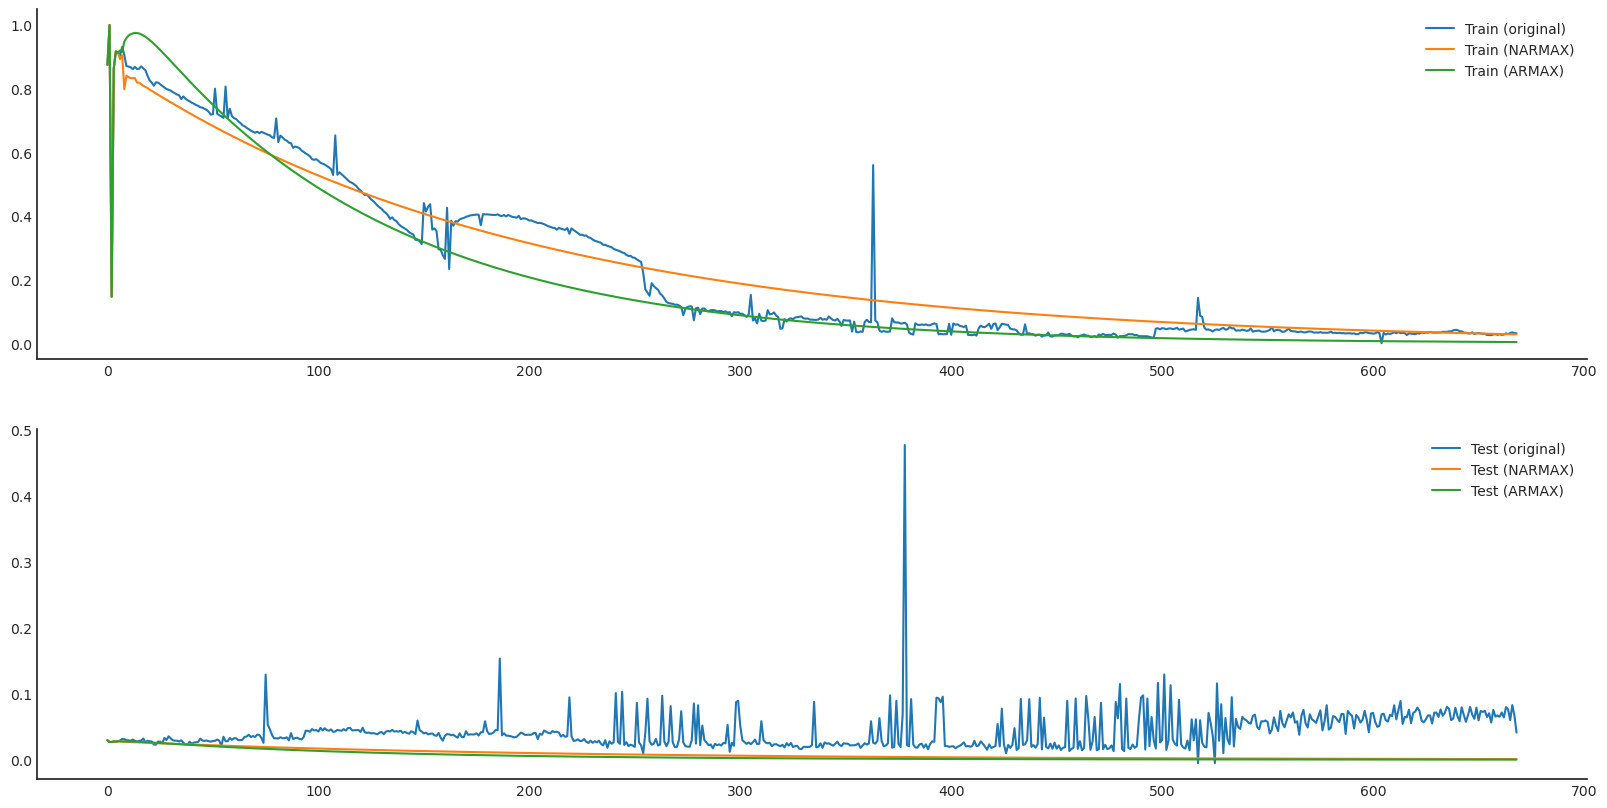

In [21]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_FS_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_FS_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [22]:
print('ARMAX Results:')
print('R2 score for FS prediction (train) :', r2_score(y_tr, y_tr_pr_FS_ARMAX))
print('R2 score for FS prediction (test)  :', r2_score(y_te, y_te_pr_FS_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for FS prediction (train) :', r2_score(y_tr, y_tr_pr_FS_NARMAX))
print('R2 score for FS prediction (test)  :', r2_score(y_te, y_te_pr_FS_NARMAX))

ARMAX Results:
R2 score for FS prediction (train) : 0.9188726986377915
R2 score for FS prediction (test)  : -1.8137003674775514

NARMAX Results:
R2 score for FS prediction (train) : 0.9476387960896399
R2 score for FS prediction (test)  : -1.6057082073516673


### 4.4 - Calculando predição com ajuste de teste de produção

In [23]:
steps = 60
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)
y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)

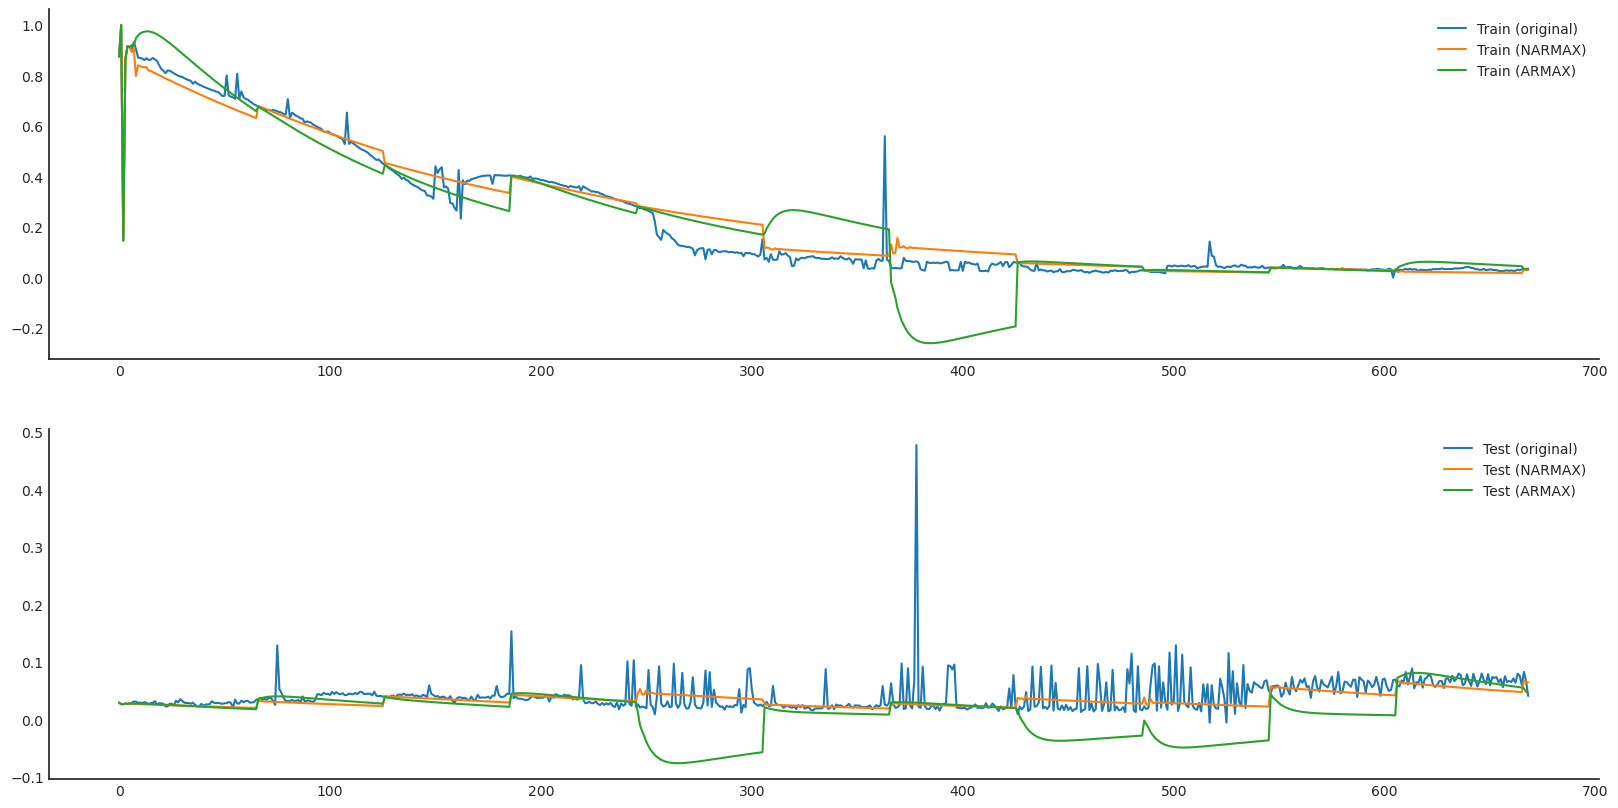

In [24]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_FS_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_FS_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [25]:
print('ARMAX Results:')
print('R2 score for n-steps prediction (train) :', r2_score(y_tr, y_tr_pr_FS_ARMAX))
print('R2 score for n-steps prediction (test)  :', r2_score(y_te, y_te_pr_FS_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for n-steps prediction (train) :', r2_score(y_tr, y_tr_pr_FS_NARMAX))
print('R2 score for n-steps prediction (test)  :', r2_score(y_te, y_te_pr_FS_NARMAX))

ARMAX Results:
R2 score for n-steps prediction (train) : 0.8286504136440622
R2 score for n-steps prediction (test)  : -2.610836044593226

NARMAX Results:
R2 score for n-steps prediction (train) : 0.9611191333596648
R2 score for n-steps prediction (test)  : 0.03386187473144753


## Passo 5 - Conclusões

FS tá ruim, mas OSA mostra que tem jogo